In [1]:
import os

In [2]:
def read_engine_config(file_name):
    try:
        with open(file_name,"r", encoding="utf8") as file:
            root = dict()
            curr = [root]
            unnamed_counter = [0]
            prev_line = ""
            for line in file:
                #Delete whitespace
                line = line.strip()
                if len(line)==0:
                    # Skip empty lines
                    continue
                if line.startswith("//"):
                    # Skip comments
                    continue
                    
                while line.startswith("%"):
                    line = line[1:]
                while line.startswith("@"):
                    line = line[1:]
                    
                if line.endswith("{"):
                    tag = ""
                    if len(line) > 1:
                        # Not just { but also name
                        tag = line[:-1]
                    else:
                        tag = prev_line
                    if tag in curr[-1].keys():
                        tag += "_%i" % unnamed_counter[-1]
                        unnamed_counter[-1] += 1
                    tag = tag.split("//")[0].strip()
                    new_dict = dict()
                    curr[-1][tag] = new_dict
                    curr.append(new_dict)
                    unnamed_counter.append(0)
                    
                    prev_line = line
                    
                    continue
                if line.endswith("}") and "{" not in line:
                    curr.pop()
                    unnamed_counter.pop()
                    prev_line = line
                    continue
                
                #Normal line
                split = line.split("=")
                if len(split) > 1:
                    tag = split[0].strip()
                    if tag in curr[-1].keys():
                        tag += "_%i" % unnamed_counter[-1]
                        unnamed_counter[-1] += 1
                    value = split[1].split("//")[0].strip()
                    
                    curr[-1][tag] = value
                else:
                    #curr[-1][split[0]] = split[0]
                    pass
                
                prev_line = line
                
            main_part = None
            engine_config = None
            for key, value in root.items():
                # Finds pretty much everything
                if "title" in value.keys():
                    main_part = value
                    break
                # Needed for RCD_Config
                if len(value) == 1:
                    if "name" in value[list(value.keys())[0]].keys():
                        main_part = value[list(value.keys())[0]]
                        engine_config = value[list(value.keys())[0]]
                        
            testflight = None
            for key, value in root.items():
                if "TESTFLIGHT" in value.keys():
                    testflight = value
            if main_part is not None and engine_config is None:
                for key, value in main_part.items():
                    if type(value) == dict and "name" in value.keys():
                        if value["name"] == "ModuleEngineConfigs" or value["name"] == "ModuleHybridEngine" or value["name"] == "ModuleBimodalEngineConfigs":
                            engine_config = value
            return root, main_part, testflight, engine_config
    except Exception as e:
        print("Error when reading "+file_name.split("//")[-1],e)

# Neater printing for dicts, there is probably some library for it...
def nice_print(val, label="", depth=0):
    if isinstance(val, dict):
        print(" "*4*depth + label + "{ ")
        for key,value in val.items():
            nice_print(value, key, depth+1)
        print(" "*4*depth + "} ")
    else:
        print(" "*4*depth + label + ": " + val)      
        


In [16]:
path = "C://Users//Simon//Simon//Spiele//Kerbal Space Program RO_RP1//GameData//RealismOverhaul//Engine_Configs//"
config_files = [path + f for f in os.listdir(path) if f.endswith(".cfg")]
surfaceISP_dict = dict()
vacuumISP_dict = dict()
minThrust_dict = dict()
maxThrust_dict = dict()
with open("scraped.csv", "w") as out:
    out.write("Name;Min. Thrust;Max. Thrust;Surface ISP;VacuumISP;Ignitions;Ullage")    
    for file in config_files:
        ret = read_engine_config(file)
        if ret is None:
            continue
        engine_dict, main, testflight, engine_config = ret
        if main is None:
            print("Main is None for %s" % file.split("//")[-1])
            continue
        if testflight is None:
            print("Testflight is None for %s" % file.split("//")[-1])
        if engine_config is None:
            print("Engine_config is None for %s" % file.split("//")[-1])
            nice_print(main)

        title = "?"
        if "title" in main.keys():
            title = main["title"]
        
        print(title)
        for key, value in engine_config.items():
            #print(key, value)
            if type(value) is dict:
                name = title + " Unknown Variant"
                if "name" in value.keys():
                    name = title + "Variant: " + value["name"]
                minThrust = "?"
                maxThrust = "?"
                ignitions = "?"
                ullage = "?"
                surfaceISP = "?"
                vacuumISP = "?"
                if "minThrust" in value.keys():
                    minThrust = float(value["minThrust"])
                if "maxThrust" in value.keys():
                    maxThrust = float(value["maxThrust"])
                if "ignitions" in value.keys():
                    ignitions = int(value["ignitions"])
                if "ullage" in value.keys():
                    ullage = value["ullage"]
                if "atmosphereCurve" in value.keys():
                    for i,val in value["atmosphereCurve"].items():
                        if val.split(" ")[0].strip() == "1":
                            surfaceISP = float(val.split(" ")[1].strip())
                        if val.split(" ")[0].strip() == "0":
                            vacuumISP = float(val.split(" ")[1].strip())
                surfaceISP_dict[name] = surfaceISP
                vacuumISP_dict[name] = vacuumISP
                minThrust_dict[name] = minThrust
                maxThrust_dict[name] = maxThrust
                #print("  ",name)
                #print("   ",minThrust, maxThrust, surfaceISP, vacuumISP, ignitions, ullage)
                out.write(name+";"+str(minThrust)+";"+str(maxThrust)+";"+
                          str(surfaceISP)+";"+str(vacuumISP)+";"+str(ignitions)+";"+str(ullage)+"\n")


???
Aerojet 1.8KS7800
Aerojet 2.5KS18000
A-4
Aerobee
Aestus Series
Testflight is None for AgenaSPS_Config.cfg
Agena-D Secondary Propulsion System
XLR81 (Agena) Vacuum Engine
AJ10-137 (Service Propulsion System)
AJ10-190
AJ10 Series (Advanced)
AJ10 Series (Early)
AJ10 Series (Mid)
AJ10 Transtar
Testflight is None for AJ260FL_Config.cfg
AJ-260 FL Solid Rocket Engine
Testflight is None for AJ260SL_Config.cfg
AJ-260 SL Solid Rocket Engine
AJ-60A
Alcyone 1A BE-3A
Algol IB
Algol III
Algol II
Altair III FW-4S
Altair II X-258
Altair X-248
AMBR
Antares I X-254
Antares IIA X-259
AR-1
Testflight is None for ASRB_Config.cfg
Advanced Booster
Astris
Baby Sergeant (5.4KS1975)
BE-3
BE-4
Testflight is None for BNTR_Config.cfg
Bimodal NTR
Cajun SRM
Castor 120
Castor 1
Castor 2
Castor 30A
Castor 30B
Castor 30XL
Castor 4AXL
Castor 4A
Castor 4
COBRA-H Engine
COBRA
Testflight is None for DFMMHPE.cfg
DFMMHPE
P 0.68 Dropt SRM
E-1
P241/A EAP
Main is None for EngineVariants_Config.cfg
F-1A Series (ETS)
F-1B
F-1

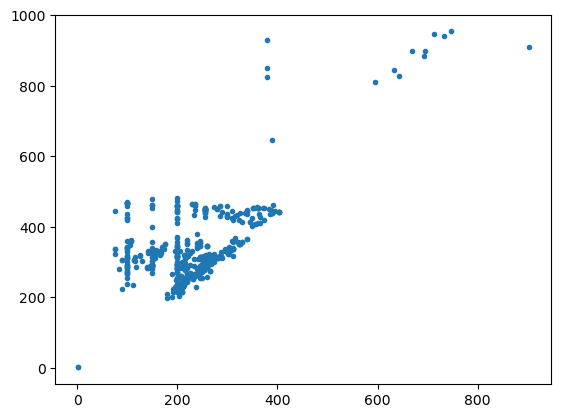

In [15]:
import matplotlib.pyplot as plt
import numpy as np

s_v = [[surfaceISP_dict[key],vacuumISP_dict[key]] for key in vacuumISP_dict.keys() if type(vacuumISP_dict[key])==float and type(surfaceISP_dict[key])==float]
s_v = np.array(s_v).T

plt.plot(s_v[0],s_v[1],marker=".",linestyle="")